In [1]:
import pandas as pd

titanic_train = pd.read_csv('./datasets/train.csv')

In [2]:
X_train, y_train = titanic_train.drop("Survived", axis=1), titanic_train['Survived']

In [274]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 59.2+ KB


Steps to take:

 num_pipeline:
     simple_imputer
   
 cat_pipeline:
     split name prefix
     impute missing objects
     encode sex: ordinal, rest OneHotEncoder()
     

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
])


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

def get_title(name):
    title_search = re.search(r'([a-zA-Z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""



class SplitName(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self = self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.applymap(get_title)
        X = X.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')        
        X = X.replace('Mlle', 'Miss')
        X = X.replace('Ms', 'Miss')
        X = X.replace('Mme', 'Mrs')
        
        return X

In [267]:
class FrequencyImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        #print(type(self.most_frequent_))
        return self
    
    def transform(self, X, y=None):
        #print(self.most_frequent_.keys())
        return X.fillna(self.most_frequent_)

In [268]:
from sklearn.preprocessing import OneHotEncoder

In [269]:
name_pipeline = Pipeline([
    ('title', SplitName()),
    ('freq_imputer', FrequencyImputer()),
    ('encoder', OneHotEncoder(sparse=True)),
])

In [270]:
cat_pipeline = Pipeline([
    ('freq', FrequencyImputer()),
    ('encoding', OneHotEncoder(sparse=True))
])

In [319]:
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())

])

cat_pipeline = Pipeline([
    
])

In [332]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('tit_pipe', name_pipeline, ['Name']),
    ('cat_atts', cat_pipeline, ['Sex', 'Embarked']),
    ('num_imputer', num_pipeline, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

])

In [333]:
prepared_X = full_pipeline.fit_transform(X_train)

In [334]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(prepared_X, y_train)

SVC(gamma='auto')

In [335]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score


def score_binary(train_labels, train_predictions):
    acc_score = accuracy_score(train_labels, train_predictions)
    return acc_score

def cross_score_binary(clf, train, train_labels, cv):
    scores = cross_val_score(clf, train, train_labels, cv)
    return scores.mean()

In [336]:
import matplotlib.pyplot as plt

def box_and_whisker(*args):
    plt.figure(figsize=(8, 4))
    plt.plot([0]*10, *args[0], ".")
    plt.boxplot([*args[0]], labels=("SVM"))
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()


In [337]:
score_binary(y_train, svm_clf.predict(prepared_X))

0.8383838383838383

In [338]:
svm_scores = cross_val_score(svm_clf, prepared_X, y_train, cv=10)
svm_scores.mean()

0.8350312109862671

In [339]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, prepared_X, y_train, cv=10)

In [340]:
forest_scores.mean()

0.8070411985018726

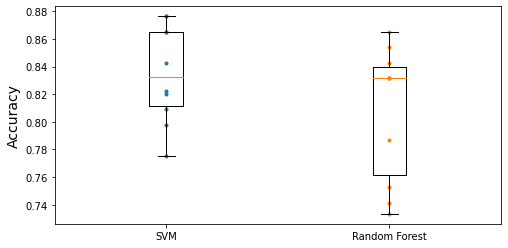

In [342]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [343]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression()
logistic_clf.fit(prepared_X, y_train)

LogisticRegression()

In [345]:
logistic_scores = cross_val_score(logistic_clf, prepared_X, y_train, cv=10)

In [346]:
logistic_scores.mean()

0.8271660424469414

In [347]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(prepared_X, y_train)

SGDClassifier()

In [348]:
sgd_scores = cross_val_score(sgd_clf, prepared_X, y_train, cv=10)
sgd_scores.mean()

0.7867915106117354

In [357]:
sgd_clf.decision_function([prepared_X[1]])

array([6.38177748])

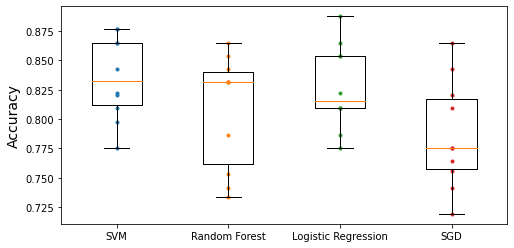

In [359]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([3]*10, logistic_scores, ".")
plt.plot([4]*10, sgd_scores, ".")
plt.boxplot([svm_scores, forest_scores, logistic_scores, sgd_scores], labels=("SVM","Random Forest", "Logistic Regression", "SGD"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

(array([1., 2., 2., 1., 4.]),
 array([0.7752809 , 0.79550562, 0.81573034, 0.83595506, 0.85617978,
        0.87640449]),
 <a list of 5 Patch objects>)

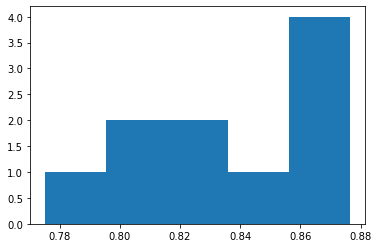

In [366]:
plt.hist(svm_scores, bins = 5) 


(array([2., 3., 1., 2., 2.]),
 array([0.7752809 , 0.79775281, 0.82022472, 0.84269663, 0.86516854,
        0.88764045]),
 <a list of 5 Patch objects>)

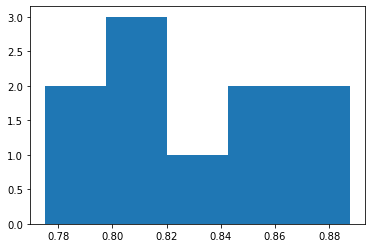

In [368]:
plt.hist(logistic_scores, bins=5)

(array([3., 0., 1., 3., 3.]),
 array([0.73333333, 0.75970037, 0.78606742, 0.81243446, 0.8388015 ,
        0.86516854]),
 <a list of 5 Patch objects>)

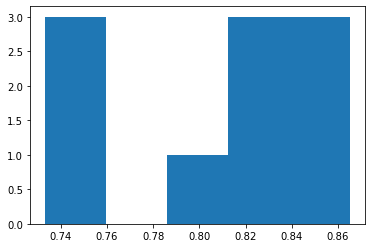

In [369]:
plt.hist(forest_scores, bins=5)

Looking at Random Forest and SVM models

In [376]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[25, 50,100,200], 'max_features':['sqrt', 'log2']}
]

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(prepared_X, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'n_estimators': [25, 50, 100, 200]}],
             return_train_score=True, scoring='accuracy')

In [377]:
grid_search.best_estimator_

RandomForestClassifier(max_features='sqrt', n_estimators=200)

In [378]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.7968426338585148 {'max_features': 'sqrt', 'n_estimators': 25}
0.7968614650681063 {'max_features': 'sqrt', 'n_estimators': 50}
0.8002322515849603 {'max_features': 'sqrt', 'n_estimators': 100}
0.8069424392693489 {'max_features': 'sqrt', 'n_estimators': 200}
0.7979976147134517 {'max_features': 'log2', 'n_estimators': 25}
0.8024668884564685 {'max_features': 'log2', 'n_estimators': 50}
0.803603038101814 {'max_features': 'log2', 'n_estimators': 100}
0.8002259745150964 {'max_features': 'log2', 'n_estimators': 200}


In [379]:
param_grid = [
    {'C':[.5,1,5,10], 'gamma':['scale','auto']}
]

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', return_train_score=True)

grid_search.fit(prepared_X, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.5, 1, 5, 10], 'gamma': ['scale', 'auto']}],
             return_train_score=True, scoring='accuracy')

In [380]:
grid_search.best_estimator_

SVC(C=1)

In [381]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.8327663046889713 {'C': 0.5, 'gamma': 'scale'}
0.8305128366078716 {'C': 0.5, 'gamma': 'auto'}
0.8350009415604795 {'C': 1, 'gamma': 'scale'}
0.8327600276191074 {'C': 1, 'gamma': 'auto'}
0.8260498399347185 {'C': 5, 'gamma': 'scale'}
0.8316489862532169 {'C': 5, 'gamma': 'auto'}
0.8193270981106018 {'C': 10, 'gamma': 'scale'}
0.8282907538760906 {'C': 10, 'gamma': 'auto'}


SVC is consistantly higher

In [382]:
import pandas as pd

titanic_test = pd.read_csv('./datasets/test.csv')

In [383]:
prepared_titanic_test = full_pipeline.fit_transform(titanic_test)

In [386]:
predicted_survivals = svm_clf.predict(prepared_titanic_test)

In [387]:
predicted_survivals

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [388]:
final_titanic_data = titanic_test[["PassengerId"]]

In [389]:
final_titanic_data = pd.DataFrame.from_dict(final_titanic_data)

In [391]:
final_titanic_data["Survived"] = predicted_survivals

In [392]:
final_titanic_data

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [393]:
final_titanic_data.to_csv('submission_v2.csv', index=False)